In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import sklearn
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from data_processing import *

In [2]:
%load_ext autoreload
%autoreload 1
%aimport data_processing

## Importing & Processing

In [3]:
dfs = get_dataframes(get_files(base_dir))
dfs[1] = dfs[1].astype(str)
dfs[1] = dfs[1][~dfs[1].posts.str.contains("http")]
dfs[2] = dfs[2][['v1','v2']]
dfs[2] = dfs[2].astype(str)
dfs = [df.dropna() for df in dfs]

In [4]:
dfs[0].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
dfs[1].head()

,type,posts
12,INFJ,'Joe santagato - ENTP|||ENFJ or ENTP? I'm n...
13,INTJ,"'Fair enough, if that's how you want to look a..."
17,INFP,'I think we do agree. I personally don't consi...
18,INFJ,'I fully believe in the power of being a prote...
19,INFP,"'That's normal, it happens also to me. If I am..."


In [6]:
dfs[2].head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
dfs[1]['type'] = dfs[1]['type'].apply(proc_label_1)
dfs[2]['v1'] = dfs[2]['v1'].apply(proc_label_2)

In [8]:
dfs[1]['posts'] = dfs[1]['posts'].astype(str).apply(word_tokenize)
dfs[2]['v2'] = dfs[2]['v2'].astype(str).apply(word_tokenize)

In [9]:
dim = 50
X1 = dfs[0].drop(['target'], axis = 1).values

v1 = Vectorizer(dim)
X2 = dfs[1]['posts'].tolist()
X2 = v1.fit_transform(X2)

v2 = Vectorizer(dim)
X3 = dfs[2]['v2'].tolist()
X3 = v2.fit_transform(X3)

y1 = dfs[0]['target'].astype(int)
y2 = dfs[1]['type'].astype(int)
y3 = dfs[2]['v1'].astype(int)

Fitting Word2Vec Model
Fitting Word2Vec Model


In [10]:
data = [(X1, y1), (X2, y2), (X3, y3)]

## Fitting Models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [12]:
arr = np.zeros((3,3))  #(3 datasets * 3 splits)

results = {
    'SVM': arr.copy(),
    'Logistic':arr.copy(),
    'Kneighbor':arr.copy()
}

In [13]:
pg1 = {'C': [.1,1,10,100,1000]}
pg2 = {'C': [.1,1,10,100,1000]}
pg3 = {'n_neighbors': np.arange(3,10,1)}

In [14]:
models = dict(Logistic=LogisticRegression(), SVM=SVC(), Kneighbor=KNeighborsClassifier())
param_grids = [pg1, pg2, pg3]
splits = [.2,.5,.8]
trials = [0,1,2]

In [15]:
import warnings
warnings.filterwarnings('ignore') 

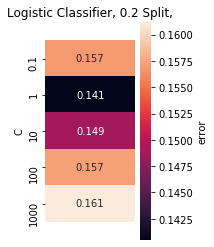

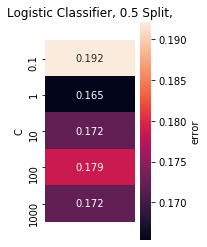

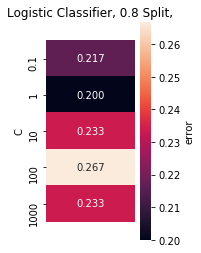

finished train & test for Logistic model


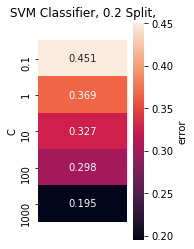

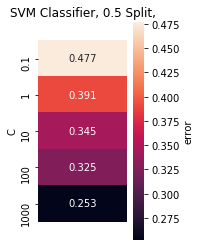

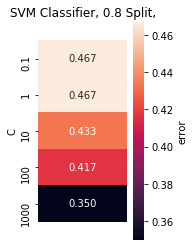

finished train & test for SVM model


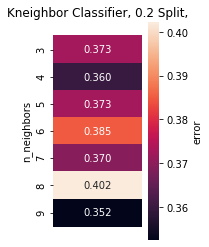

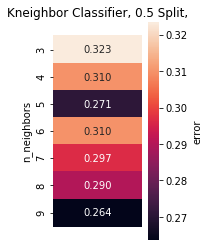

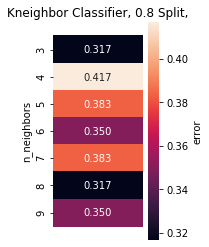

finished train & test for Kneighbor model


In [16]:
for pg, (name, model) in zip(param_grids, models.items()):
    for d_ind, d in enumerate(data):
        for s_ind, split in enumerate(splits):
            tr = []
            for trial in trials:
                tr.append(cv_model(name, model, pg, d, split, trial, d_ind, cv=10))
            results[name][s_ind][d_ind] = np.mean(np.array(tr))
    print(f'finished train & test for {name} model')

## Comparison by dataset

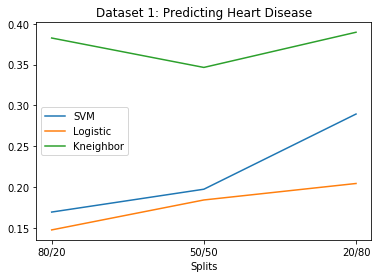

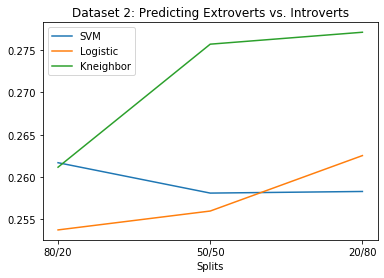

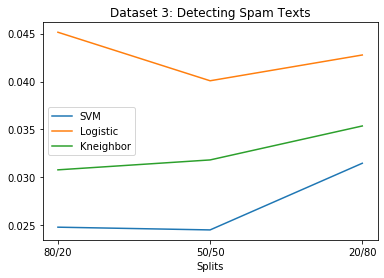

In [17]:
titles = ["Dataset 1: Predicting Heart Disease",
          "Dataset 2: Predicting Extroverts vs. Introverts",
          "Dataset 3: Detecting Spam Texts"]

for ind, title in enumerate(titles):
    plt.figure()
    for model_name in results.keys():
        plt.plot(results[model_name][:,ind], label = model_name)
        plt.xticks(ticks = [0,1,2], labels = ['80/20', '50/50', '20/80'])
        plt.xlabel('Splits')
        plt.legend(loc='best')
    plt.title(title);

## Ranking

In [18]:
result_avg = {k:v.mean(axis = 0) for (k,v) in results.items()}  #average across splits

In [19]:
result_avg

{'SVM': array([0.21873497, 0.25934191, 0.02693985]),
 'Logistic': array([0.17871369, 0.25739649, 0.04266431]),
 'Kneighbor': array([0.37285988, 0.27133498, 0.03266172])}

In [31]:
final = comp_results(result_avg)

In [34]:
cls = list(result_avg.keys())
order = np.argsort(-final[:,0])
[print(f'{cls[order[i]]} Results: {final[order[i]]}') for i in range(len(order))];

Logistic Results: [0.66666667 0.         0.33333333]
SVM Results: [0.33333333 0.66666667 0.        ]
Kneighbor Results: [0.         0.33333333 0.66666667]
